In [155]:
import numpy as np
from larch import Group
from glob import glob
import re
import matplotlib.pyplot as plt
from os import path
import os
!git clone https://github.com/kaifengZheng/zanes.git
from zanes.zanes import data_analysis as da
from scipy.interpolate import interp1d
import pandas as pd


fatal: destination path 'zanes' already exists and is not an empty directory.


# data analysis for non-modulation measurements

fatal: destination path 'zanes' already exists and is not an empty directory.


In [62]:
def data_collect(datadict,tag):
    E_achi,mu_achi,mu_achi_get,E_achi=[],[],[],[]
    E_max,E_min=[],[]
    for file  in datadict[tag]:
        E_get,mu_get=read_data(file)
        E_achi.append(E_get)
        mu_achi.append(mu_get)
        E_max.append(E_get[-1])
        E_min.append(E_get[0])
    E_mesh=np.linspace(np.max(E_min),np.min(E_max),500)
    for i in range(len(mu_achi)):
        mu_achi_get.append(interp1d(E_achi[i],mu_achi[i])(E_mesh))
    return E_mesh,np.array(mu_achi_get)

def get_ave(E,mu):
    return E,mu.mean(axis=0)
def plot_data(E,mu,tag):
    for i in range(len(mu)):
        if i==0:
            plt.plot(E,mu[i],label=tag,alpha=0.3)
        else:
            plt.plot(E,mu[i],alpha=0.3)
    plt.plot(E,mu.mean(axis=0),label='mean',color='red')
    plt.legend(frameon=False)
    
def get_datadict(filenames):
    name_dict=dict()
    for name in filenames:
        basednames=path.basename(name)
        match_name=re.match('(^.+)\s+',basednames)[0]
        if match_name not in name_dict.keys():
            name_dict[match_name]=[]
        if match_name in name:
            name_dict[match_name].append(name)
    return name_dict
def read_data(filename):
    data=np.loadtxt(filename,comments='#')
    return data[:,0],data[:,4]/data[:,1] #flou data

def get_larch_groups(datadict,tag):
    E_achi,mu_achi=data_collect(datadict,tag)
    
    groups=[]
    for i in range(len(mu_achi)):
        groups.append(Group(energy=E_achi,mu=mu_achi[i],label=path.basename(datadict[tag][i])))
    return groups
              

In [61]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/2/315439/*.dat"), key=os.path.getmtime,reverse=True)

In [7]:
name_dict=get_datadict(filenames)

In [8]:
keys=list(name_dict.keys())
print("show key_num and corresponding measurement")
for i in range(len(keys)):
    print(f"{i}\t{keys[i]}")

show key_num and corresponding measurement
0	ME05_Pd20_S1_at_200C_30sO2_30sCH4_60cycles 
1	SS04_Pd20_S1_at_200C_in_O2 
2	DC03_Pd20_S1_during_cooling_400C_to_200C 
3	Pd20_S1_O2-Pretreatment_at_400C 
4	Pd20_S1_O2-Pretreatment_During_Heating_RT_to_400C 
5	Pd20_S1_Init_at_RT_in_Air 
6	test_3223 
7	PdRT_no_detune_30s_fly 
8	PdRT_no_detune_ocs 
9	PdRT_no_detune 
10	PdRT 
11	pd_sample_Test_10osci 
12	pd_sample_Test_30s 
13	pd_sample_Test 
14	test5 
15	test4 
16	test3 
17	test2 
18	test 
19	pd osc4 20 
20	pd osc3 10 
21	pd osc2 10 
22	pd osc 10 
23	Pd_foil_after_calib 
24	Pd_foil_before_calib 


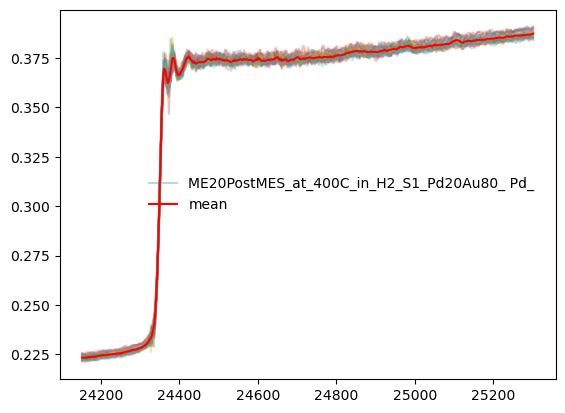

In [7]:
key_num=3
E,mu=data_collect(name_dict,keys[key_num])
plot_data(E,mu,keys[key_num])
E_ave,mu_ave=get_ave(E,mu)

In [8]:
groups=get_larch_groups(name_dict,tag=keys[key_num])
group_ave=Group(energy=E_ave,mu=mu_ave,label=keys[key_num])

In [9]:
for i in range(len(groups)):
    da.data_processing(groups[i],e0=None, pre_start=-200,pre_end=-60,post_start=80,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,8])


E0=24350.17348929459


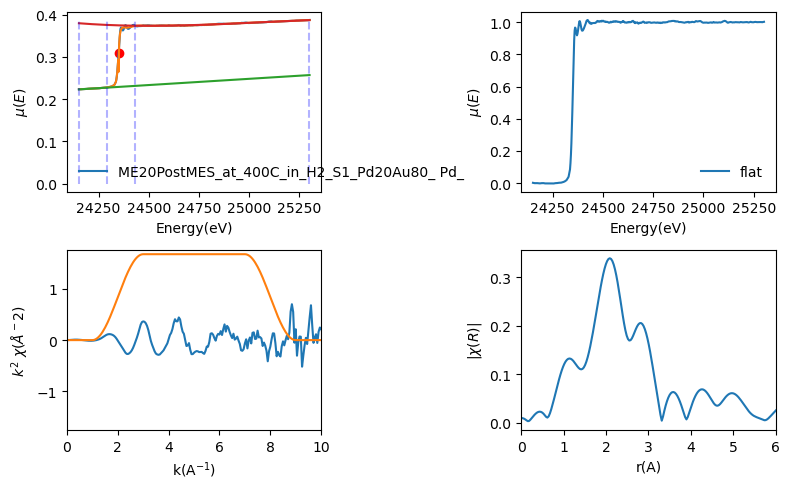

In [10]:
da.data_processing(group_ave,e0=None, pre_start=-200,pre_end=-60,post_start=80,post_end=950,kweight=2,rbkg=1,
                  plot=True,kwin='hanning',dk=2,krange=[2,8])

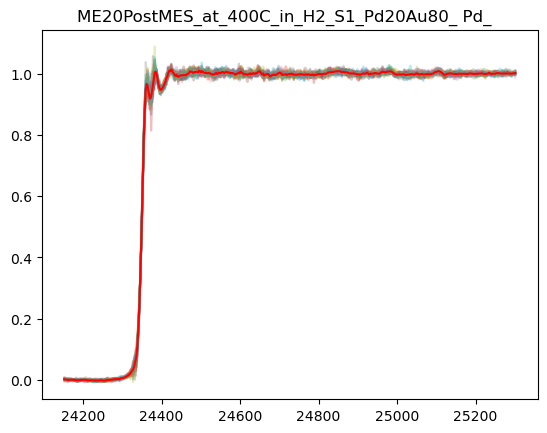

In [11]:
plt.figure()
for i in range(len(groups)):
    plt.plot(groups[i].energy,groups[i].flat,alpha=0.3)
plt.title(keys[key_num])
plt.plot(group_ave.energy,group_ave.flat,color='red')

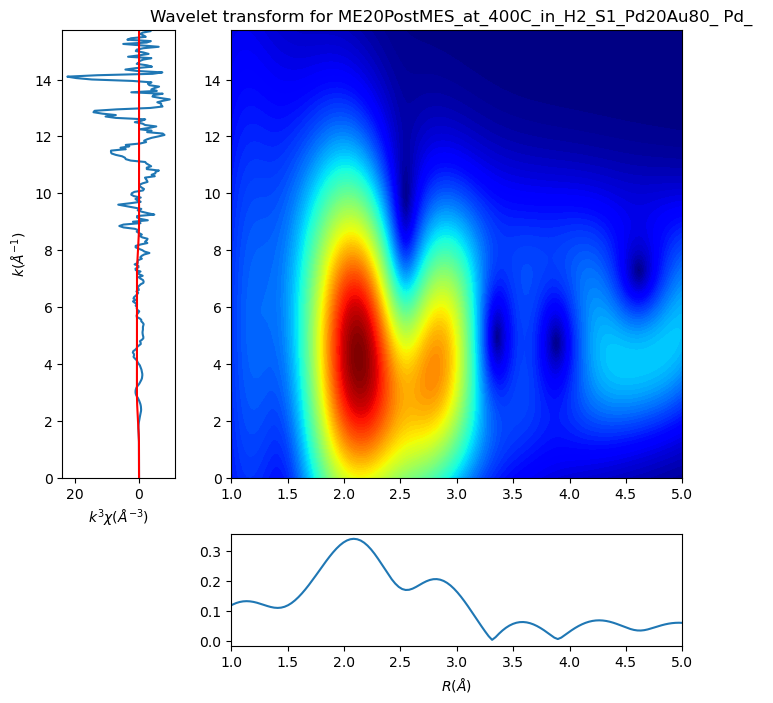

In [12]:
da.wavelet_transform(group_ave, kweight=2, plot=True) #wavelet transform

# data analysis for modulation measurements

In [208]:
from scipy.interpolate import interp1d
def read_data(filename):
    data=np.loadtxt(filename,comments='#')
    return data[:,0],data[:,4]/data[:,1] #flou data
def data_dict_modu(filenames):
    name_dict=dict()
    for name in filenames:
        basedname=path.basename(name)
        # print(basednames)
        match_name='_'.join(basedname.split('_')[:-2])
        traj_num=int(basedname.split('_')[-2].split(' ')[1])
        # print(f"{name} {cycle_num}")
        scan_num=int(basedname.split('_')[-1].split('.')[0])
        up_down=basedname.split('_')[2]
        if match_name not in name_dict.keys():
            name_dict[match_name]=[{'full_path':name,
                                   "tag":match_name,
                                   "traj_num":traj_num,
                                   "scan_num":scan_num,
                                   "up_down":up_down}]
        else:
            name_dict[match_name].append({'full_path':name,
                                   "tag":match_name,
                                   "traj_num":traj_num,
                                   "scan_num":scan_num,
                                   "up_down":up_down})
    return name_dict
def data_collect(filelist):
    E_achi,mu_achi=[],[]
    for file  in filelist:
        E_get,mu_get=read_data(file)
        E_achi.append(E_get)
        mu_achi.append(mu_get)
    return E_achi,mu_achi
def name_collect(dict_modu,tag,mode='first',traj_num=2,total_scan=100,scans_per_period=10): #'dn'
    names=[]
    datapoints=dict_modu[tag]
    period=np.int32(np.floor(total_scan/scans_per_period))
    # first_batch=[i*10+j for i in range(period) for j in range(i*10,(i+1)*10) ]
    first=[]
    second=[]
    for i in range(period):
        for j in range(total_scan):
            if j>i*period or i*period==0:
                if j in range(i*period,i*period+period//2):
                    first.append(datapoints[i]['full_path'])
                else:
                    second.append(datapoints[i]['full_path'])
            if j==(i+1)*period:
                break
    if mode=='first':
        # if data['scan_num']==
        names=first
    if mode=='second':
        names=second
    return names
def name_collect_alltraj(dict_modu,tag,mode='H2',total_scan=100):
    datapoints=dict_modu[tag]
    traj_num=np.unique(np.array([int(datapoints[i]['traj_num']) for i in range(len(datapoints))]))
    names=[]
    for i in range(len(traj_num)):
        names_col=name_collect(dict_modu,tag,mode=mode,traj_num=traj_num[i],total_scan=total_scan)
    names.extend(names_col)
    return names
def name_collect3(dict_modu,tag,mode='first',traj_num=2,total_scan=36,scans_per_period=10): #'dn'
    names=[]
    datapoints=dict_modu[tag]
    period=np.int32(np.floor(total_scan/scans_per_period))
    # first_batch=[i*10+j for i in range(period) for j in range(i*10,(i+1)*10) ]
    first=[]
    second=[]
    for i in range(period):
        for j in range(total_scan):
            if j >=i*period:
                if j in range(i*period,i*period+period//3):
                    first.append(datapoints[i]['full_path'])
                elif j in range(i*period+period//3,i*period+period*2//3):
                    second.append(datapoints[i]['full_path'])
                else:
                    third.append(datapoints[i]['full_path'])
            if j==(i+1)*period:
                break
    if mode=='first':
        # if data['scan_num']==
        names=first
    if mode=='second':
        names=second
    if mode=='third':
        names=third
    return names
def plot_data(E,mu,tag,color='r',alpha=0.3):
    for i in range(len(mu)):
        if i==0:
            plt.plot(E[i],mu[i],label=tag,alpha=alpha)
        else:
            plt.plot(E[i],mu[i],alpha=alpha)
    plt.plot(E.mean(axis=0),mu.mean(axis=0),label='mean',color=color)
    plt.legend(frameon=False)
def get_larch_groups(filenames):
    E_achi,mu_achi=data_collect(filenames)
    groups=[]
    for i in range(len(E)):
        groups.append(Group(energy=E_achi[i],mu=mu_achi[i],label=path.basename(filenames[i])))
    return groups
def get_ave(E,mu):
    return E.mean(axis=0),mu.mean(axis=0)
def get_ave_cycle(data_dict,key_num,mode='first',traj_num=2,total_scan=36,scans_per_period=20):
    """
    data_dict: return value of function data_dict_modu(filenames): details of file information
    key_num: The specific measurement index. 
    """
    traj=[]
    e_all=[]
    mu_all=[]
    for k in data_dict[key[key_num]]:
        if k['traj_num'] not in traj:
            traj.append(k['traj_num'])
    print(f"num of trajactories:{traj}")
    for t in traj:
        data=name_collect(data_dict,key[key_num],mode=mode,traj_num=t,total_scan=total_scan,scans_per_period=scans_per_period)
        e1,mu1=data_collect(data)
        for i in range(len(e1)):
            e_all.append(np.array(e1[i]))
            mu_all.append(np.array(mu1[i]))
    # print(e_all)
    e,mu=interp_data(e_all,mu_all)
    
    e_all=np.array(e)
    mu_all=np.array(mu).mean(axis=0)
    # print(e_all.mean(axis=0))
    return e_all,mu_all

def get_ave_cycle3(data_dict,key_num,mode='first',traj_num=2,total_scan=10):
    """
       This script works for the modulation between O, H2 and CH4
    """
    traj=[]
    e_all=[]
    mu_all=[]
    for k in dic[key[key_num]]:
        if k['traj_num'] not in traj:
            cycles.append(k['traj_num'])
    print(f"traj:{traj}")
    for t in traj:
        data=name_collect3(data_dict,key[key_num],mode=mode,traj_num=t,total_scan=total_scan,scans_per_period=scans_per_period)
        e1,mu1=data_collect(data)
        for i in range(len(e1)):
            e_all.append(np.array(e1[i]))
            mu_all.append(np.array(mu1[i]))
    # print(e_all)
    e_all=np.array(e_all).mean(axis=0)
    mu_all=np.array(mu_all).mean(axis=0)
    # print(e_all.mean(axis=0))
    return e_all,mu_all
def interp_data(e_collect,mu_collect):
    e_max=min([e_collect[i][-1] for i in range(len(e_collect))])
    e_min=max([e_collect[i][0] for i in range(len(e_collect))])
    e_len=max([len(e_collect[i]) for i in range(len(e_collect))])
    e=np.linspace(e_min,e_max,e_len)
    mu=[interp1d(e_collect[i],mu_collect[i])(e) for i in range(len(e_collect))]
    return e,mu
    
    
    

In [198]:
%matplotlib widget

In [199]:
# def read_data(filename):
#     data=np.loadtxt(filename,comments='#')
#     return data[:,0],data[:,4]/data[:,1] #flou data
# # read_data
# read_data(filenames[0])[0]
# def data_collect(filelist):
#     E_achi,mu_achi=[],[]
#     for file  in filelist:
#         E_get,mu_get=read_data(file)
#         E_achi.append(E_get)
#         mu_achi.append(mu_get)
# data_collect(filenames)

In [200]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/2/315439/Oscillatory_processed/ME*.dat"), key=os.path.getmtime,reverse=True)
data_dict=data_dict_modu(filenames)
key=list(data_dict.keys())
print("show key_num and corresponding measurement:")
for i in range(len(key)):
    print(f"{i}\t{key[i]}")

show key_num and corresponding measurement:
0	ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4
1	ME05_1st_up_ME05_Pd20_S1_at_200C_30sO2_30sCH4
2	ME06_1st_dn_ME06_Pd20_S1_at_200C_5sO2_5sCH4
3	ME06_1st_up_ME06_Pd20_S1_at_200C_5sO2_5sCH4


In [201]:
key_num=0
traj_num=1
table=pd.DataFrame(data_dict[key[key_num]])
total_scan=len(table)
print(f"total {key[key_num]} spectra: {len(table)}")

table[table['traj_num']==traj_num].head()
# table: row number is the total scan

total ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4 spectra: 450


,full_path,tag,traj_num,scan_num,up_down
400,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4,1,100,dn
401,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4,1,98,dn
402,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4,1,96,dn
403,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4,1,94,dn
404,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4,1,92,dn


In [210]:
E_CH4,mu_CH4=get_ave_cycle(data_dict,key_num,mode='first',traj_num=traj_num,total_scan=total_scan,scans_per_period=20)
E_O2,mu_O2=get_ave_cycle(data_dict,key_num,mode='second',traj_num=traj_num,total_scan=total_scan,scans_per_period=20)
# E_CH4,mu_CH4=get_ave_cycle3(dic,key_num,mode='CH4',cycle_num=cycle_num,total_scan=total_scan)


num of trajactories:[9, 8, 7, 6, 5, 4, 3, 2, 1]
num of trajactories:[9, 8, 7, 6, 5, 4, 3, 2, 1]


In [211]:
group_ave1=Group(energy=E_CH4,mu=mu_CH4,label=f"CH4_traj_{traj_num}")
group_ave2=Group(energy=E_O2,mu=mu_O2,label=f'O2_traj_{traj_num}')
# group_ave3=Group(energy=E_CH4,mu=mu_CH4,label=f'CH4_cyc_{cycle_num}')

E0=24352.367280833776


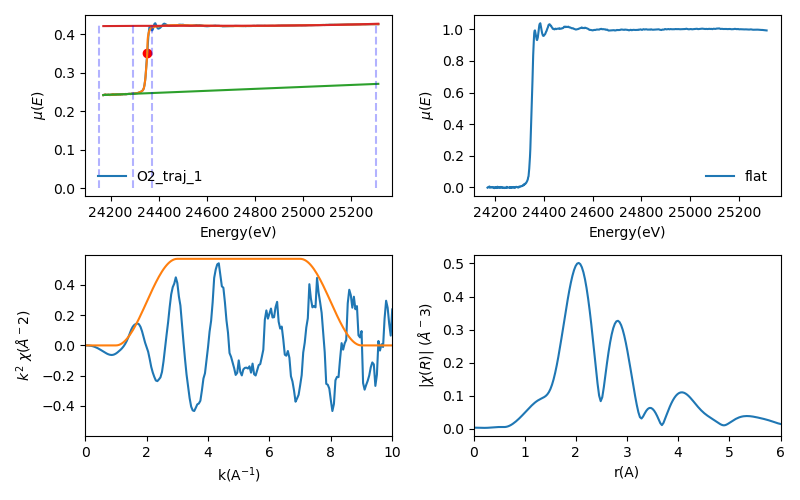

In [212]:
da.data_processing(group_ave1,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,8])
da.data_processing(group_ave2,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=True,kwin='hanning',dk=2,krange=[2,8])
# da.data_processing(group_ave3,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
#                   plot=True,kwin='hanning',dk=2,krange=[2,8])

Text(0.5, 1.0, 'ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4')

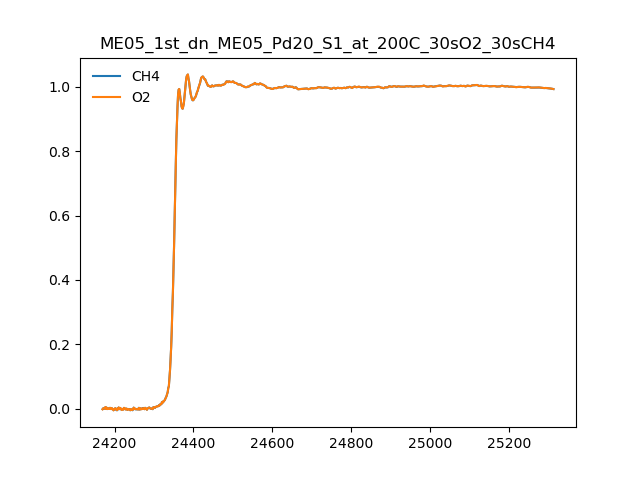

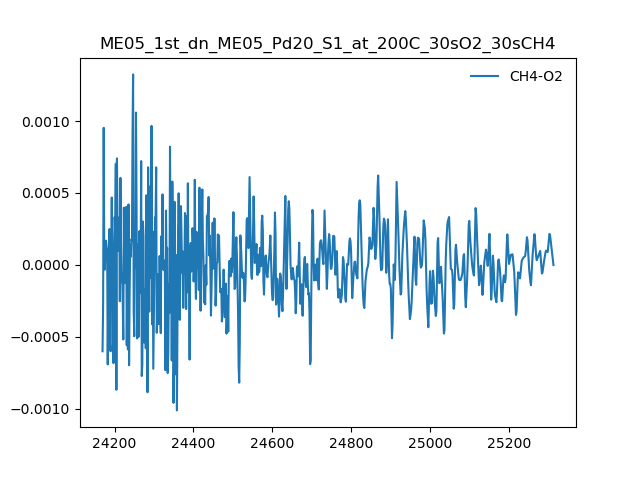

In [213]:
plt.figure()
plt.plot(group_ave1.energy,group_ave1.flat,label='CH4')
plt.plot(group_ave2.energy,group_ave2.flat,label='O2')
# plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
plt.legend(frameon=False)
plt.title(key[key_num])
plt.figure()
plt.plot(group_ave1.energy,group_ave2.flat-group_ave1.flat,label='CH4-O2')
# plt.plot(group_ave2.energy,group_ave2.flat,label='CH4')
# plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
plt.legend(frameon=False)
plt.title(key[key_num])

Text(0.5, 1.0, 'ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4')

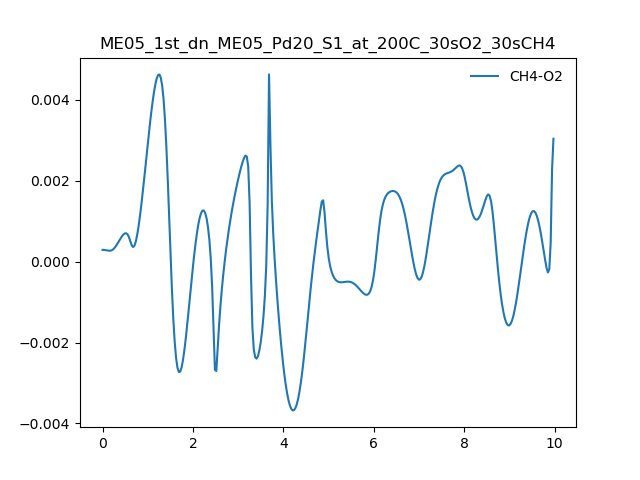

In [215]:

plt.figure()
plt.plot(group_ave1.r,group_ave2.chir_mag-group_ave1.chir_mag,label='CH4-O2')
# plt.plot(group_ave2.energy,group_ave2.flat,label='CH4')
# plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
plt.legend(frameon=False)
plt.title(key[key_num])

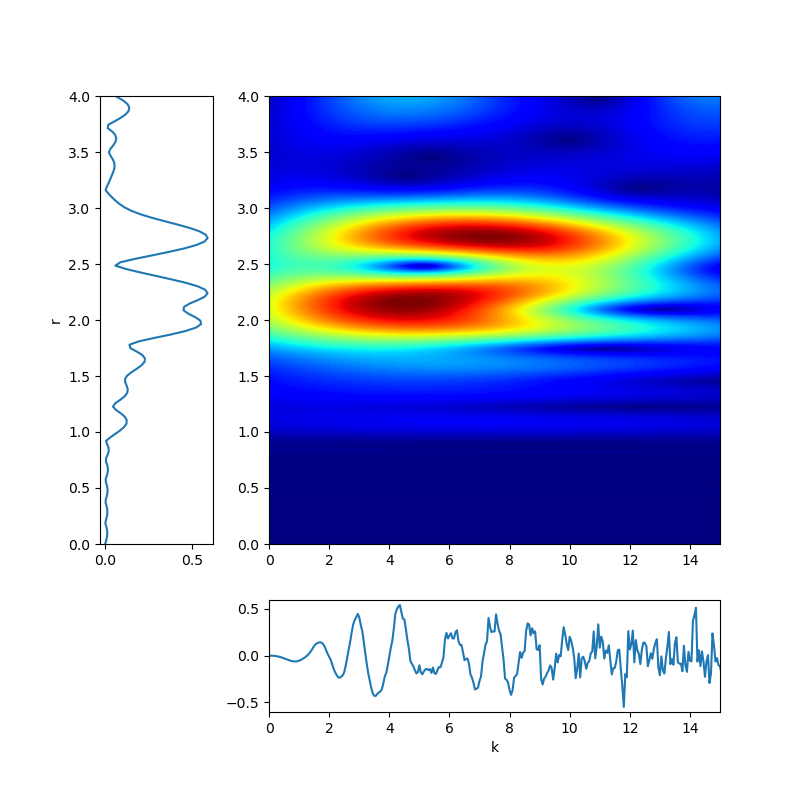

In [219]:
da.wavelet_transform(group_ave1, kweight=2,  plot_spec={'rrange':[0,4],'krange':[0,15]})

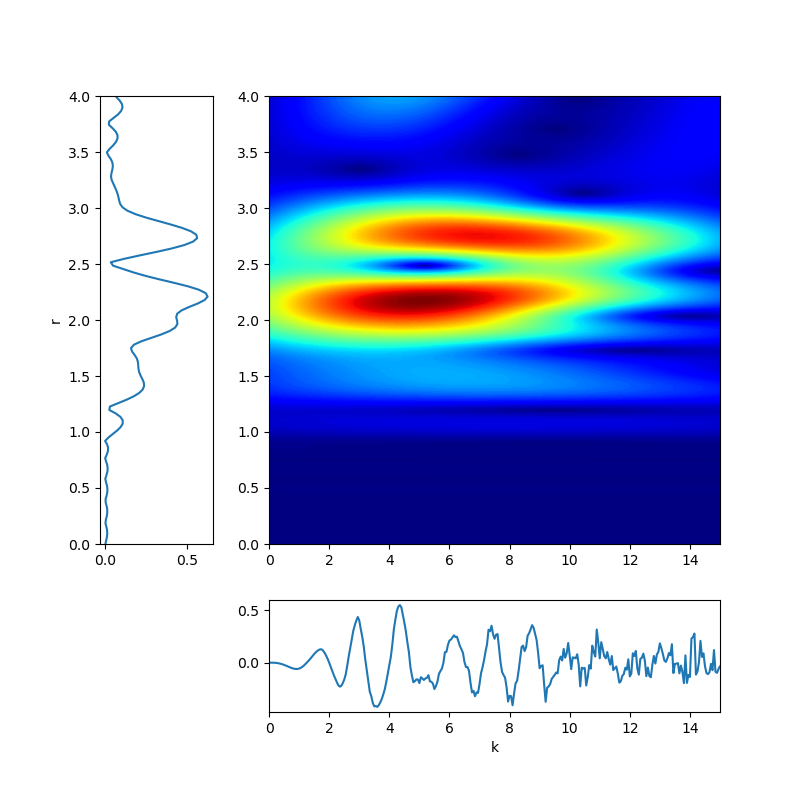

In [138]:
da.wavelet_transform(group_ave2, kweight=2,plot_spec={'rrange':[0,4],'krange':[0,15]})

In [23]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/1/313272/Oscillatory_processed/*.dat"), key=os.path.getmtime,reverse=True)
dic=data_dict_modu(filenames)
key=list(dic.keys())
for i in range(len(key)):
    print(f"{i}\t{key[i]}")

0	ME19_MES_at_400C_15sCH4_15sO2_S1_Pd20Au80_ Pd_37osci_ 
1	ME18_MES_at_400C_15sH2_15sO2_S1_Pd20Au80_ Pd_37osci_ 
2	ME17_MES_at_250C_30sH2_30sO2_30sCH4_S1_Pd20Au80_ Pd_28osc_ 
3	ME16_MES_at_250C_60sCH4_60sO2_S1_Pd20Au80_ Pd_60s60s_18osc_ 
4	ME15_MES_at_250C_60ssH2_60sO2_S1_Pd20Au80_ Pd_60s60s_18osc_ 
5	ME14_MES_at_250C_30sCH4_30sO2_S1_Pd20Au80_ Pd_60s60s_18osc_ 
6	ME13_MES_at_250C_15sH2_15sO2_S1_Pd20Au80_ Pd_37osci_ 
7	ME12_MES_at_250C_15sCH4_15sO2_S1_Pd20Au80_ Pd_37osci_ 
8	ME11_MES_at_250C_60sCH4_60sO2_S1_Pd20Au80__after_O260s_H260s_ Pd_60s60s_18osc_ 
9	ME02MES1_S1_Pd20Au80_fromH2_120sO2_120H2_ Pd_36osci_ 
10	ME02MES1_S1_Pd20Au80_fromH2_120sO2_120H2_ Pd_35osci_ 
11	ME04MES1_H2_S2_Pd8Au92_ fromH2_60sO2_60sH2_ Pd_18osci_ 
12	ME04DuringheatingMES1_400_H2_S2_Pd8Au92_ Pd_Al foil_ 
13	ME01_S1_Pd20Au80_fromH2_60sO2_60sH2_30cycles_
14	ME03MES1_S1_Pd20Au80_fromH2_15sO2_15H2_ Pd_37osci_ 
15	ME01PostMES1_H2_S1_Pd20Au80_
16	S1_Pd_20
17	S1_Pd_20_test
18	test_pd_osci
